In [1]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from analysis_utils import *
from scipy.stats import norm

os.chdir('../')
os.getcwd()

'/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment'

Load data into Pandas dataframe. To be implemented: run some tests to ensure data quality

- does run exist? 
- does run contain responses?
- does run log color_balance and fix_intensity values correctly?

# Analysis of 2AFC Attn Task

In psychophysics task participants respond to each trial indicating whether the stimulus presented is more dark or more light.

**Note:** Response Left (color_balance < 0.5) = Dark; Response Right (color_balance > 0.5) = Light.

In [4]:
f_names = glob.glob("logs/psychophys/*/*.tsv")
all_logs = load_data(f_names)
all_logs.tail(10)

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,run
890,220,234.877463,stim,0,NaN,167.0,0.70,-0.4,240.176188,1.624995,236.502457,241.801183,largeAF,15
891,220,236.488646,response,0,right,0.0,0.70,-0.4,241.787371,0.000000,236.488646,241.787371,largeAF,15
892,221,236.502457,stim,0,NaN,157.0,0.55,0.6,241.801183,1.632882,238.135339,243.434064,largeAF,15
893,221,238.127091,response,0,left,0.0,0.55,0.6,243.425816,0.000000,238.127091,243.425816,largeAF,15
894,222,238.135339,stim,0,NaN,124.0,0.45,-0.6,243.434064,1.291574,239.426913,244.725638,largeAF,15
895,222,239.418662,response,0,right,0.0,0.45,-0.6,244.717387,0.000000,239.418662,244.717387,largeAF,15
896,223,239.426913,stim,0,NaN,55.0,0.65,0.0,244.725638,0.575511,240.002424,245.301149,largeAF,15
897,223,239.988617,response,0,right,0.0,0.65,0.0,245.287342,0.000000,239.988617,245.287342,largeAF,15
898,224,240.002424,stim,0,NaN,189.0,0.55,0.2,245.301149,1.965955,241.968379,247.267104,largeAF,15
899,224,241.951868,response,0,left,0.0,0.55,0.2,247.250593,0.000000,241.951868,247.250593,largeAF,15


In [71]:
df = all_logs[all_logs.event_type == 'response']
df['correct'] = np.nan

true_left = df[(df.color_balance < 0.5) & (df.response == 'left')].index
false_left = df[(df.color_balance > 0.5) & (df.response == 'left')].index

true_right = df[(df.color_balance > 0.5) & (df.response == 'right')].index
false_right = df[(df.color_balance < 0.5) & (df.response == 'right')].index

print(f'Total response "right": {sum(df.response == "left")} \
    \nTotal response "left": {sum(df.response == "right")} \
    \ntrue_left: {len(true_left)/sum(df.color_balance < 0.5)} \
    \ntrue_right: {len(true_right)/sum(df.color_balance > 0.5)} \
    \nfalse_left: {len(false_left)/sum(df.color_balance < 0.5)} \
    \nfalse_right: {len(false_right)/sum(df.color_balance > 0.5)}')

Total response "right": 236     
Total response "left": 214     
true_left: 0.4979919678714859     
true_right: 0.4301675977653631     
false_left: 0.40963855421686746     
false_right: 0.6983240223463687


In [72]:
df.loc[np.hstack((true_left,true_right)), 'correct'] = 1
df.loc[np.hstack((false_left,false_right)), 'correct'] = 0
df = df.dropna() # drop where color balance = 0.5
df.head()

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,run,correct
1,0,1.660374,response,0,left,0.0,0.55,0.06,7.423584,0.0,1.660374,7.423584,largeAF,13,0.0
3,1,2.515597,response,0,left,0.0,0.55,0.06,8.278807,0.0,2.515597,8.278807,largeAF,13,0.0
5,2,3.768944,response,0,right,0.0,0.55,0.00,9.532154,0.0,3.768944,9.532154,largeAF,13,1.0
9,4,5.572045,response,0,left,0.0,0.45,0.06,11.335255,0.0,5.572045,11.335255,largeAF,13,1.0
11,5,6.593737,response,0,right,0.0,0.35,-0.10,12.356947,0.0,6.593737,12.356947,largeAF,13,0.0


Color balance: 0.30, prop_correct:0.45
Color balance: 0.20, prop_correct:0.49
Color balance: 0.15, prop_correct:0.36
Color balance: 0.10, prop_correct:0.41
Color balance: 0.05, prop_correct:0.63
Color balance: 0.05, prop_correct:0.32
Color balance: 0.10, prop_correct:0.57
Color balance: 0.15, prop_correct:0.46
Color balance: 0.20, prop_correct:0.36
Color balance: 0.30, prop_correct:0.50


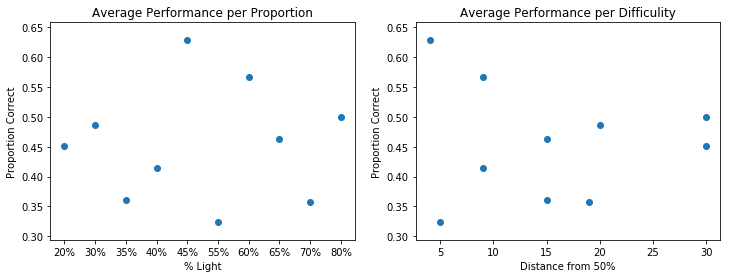

In [111]:
difficulties = sorted(df[(df.run == '13')].color_balance.unique())
proportions = []

for diff in difficulties:
    print(f'Color balance: {abs(0.5 - diff):.2f}, prop_correct:{sum(df[df.color_balance == diff].correct)/len(df[df.color_balance == diff].correct):.2f}')
    proportions.append(sum(df[df.color_balance == diff].correct)/len(df[df.color_balance == diff].correct))

fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].set_title('Average Performance per Proportion')
axs[0].set_ylabel('Proportion Correct')
axs[0].set_xlabel('% Light')
axs[0].scatter([f'{int(i*100)}%' for i in difficulties],proportions)

axs[1].set_title('Average Performance per Difficulity')
axs[1].set_ylabel('Proportion Correct')
axs[1].set_xlabel('Distance from 50%')
axs[1].scatter([int(abs(0.5-i)*100) for i in difficulties],proportions)

# Analysis of Attn PRF Detection Task

In [ ]:
f_names = glob.glob("logs/*/*.tsv")
all_logs = load_data(f_names)
all_logs[(all_logs.run == '12')].head(25)

Calculate correct and incorrect responses. Use this to get hits (true positives), misses (false negatives), false alarms (false positives) and correct rejections (true negatives). Once we have these values we can calculate d' and the criterion (c). 

### Summary per run

In [ ]:
psyc, d_primes, large_cor, small_cor = analyse_logs(all_logs)
psyc

We can also calculate d' per difficulty level and plot this to see if two task difficulties are comparable. Unfortunately d' can go to infinity so many points are missing from the performance curves... and we're unsure if they're sigmoidal.

In [ ]:
Z = norm.ppf
d_primes['d_prime']= Z(d_primes['hit_rate'])- Z(d_primes['fa_rate'])
d_primes['criterion'] = -(Z(d_primes['hit_rate']) + Z(d_primes['fa_rate'])) / 2
d_primes.head()

In [ ]:
large_AF = d_primes[d_primes['run'].astype(int) % 2 == 1]
small_AF = d_primes[d_primes['run'].astype(int) % 2 == 0]

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.set_title('SmallAF')
ax1.scatter(abs(small_AF['difficulty']),small_AF['d_prime'])
ax1.set_ylabel('Dprime')

ax2.set_title('LargeAF')
ax2.scatter(abs(large_AF['difficulty']-0.5),large_AF['d_prime'],color='orange')
ax2.set_ylabel('Dprime')

We can also use proportion correct to create psychometric curves - although these are not traditional sigmoidal psychometric curves which are designed for 2 alternative forced-choice (2AFC) task. 

In [ ]:
largex, largey = (np.array([i[0] for i in large_cor]), 
                  np.array([i[1] for i in large_cor]))
smallx,smally = (np.array([i[0] for i in small_cor]), 
                np.array([i[1] for i in small_cor]))

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,8))

ax1.set_title('LargeAF_Sigmoid')
ax1.scatter([abs(i[0]-0.5) for i in large_cor], [i[1] for i in large_cor])
ax1.set_ylabel('Proportion Correct')

ax2.set_title('LargeAF_Gauss')
ax2.scatter([i[0] for i in large_cor], [i[1] for i in large_cor])
ax2.set_ylabel('Proportion Correct')

ax3.set_title('SmallAF_Sigmoid')
ax3.set_ylim(0,1)
ax3.scatter([abs(i[0]-0) for i in small_cor], [i[1] for i in small_cor], color='orange')

ax4.set_title('SmallAF_Gauss')
ax4.set_ylim(0,1)
ax4.scatter([i[0] for i in small_cor], [i[1] for i in small_cor], color='orange')

Lastly we can fit a sigmoid function to each of these curves.

In [ ]:
def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y

xdata = abs(largex-0.5) # abs(large_AF['difficulty']-0.5)[large_AF.replace([np.inf,-np.inf],np.nan).dropna().index]
ydata = largey # large_AF.replace([np.inf,-np.inf],np.nan).dropna()['d_prime']

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

x = np.linspace(0.0, 0.4, 20)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.title('LargeAF')
plt.plot(x,y, label='fit')
plt.ylim(0, 1)
plt.ylabel('proportion correct')
plt.legend(loc='best')
plt.show()

xdata = abs(smallx) # abs(small_AF['difficulty'])[small_AF.replace([np.inf,-np.inf],np.nan).dropna()['d_prime'].index]
ydata = smally # small_AF.replace([np.inf,-np.inf],np.nan).dropna()['d_prime']

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

x = np.linspace(0.0, 0.1, 20)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.title('SmallAF')
plt.plot(x,y, label='fit')
plt.ylim(0, 1)
plt.ylabel('proportion correct')
plt.legend(loc='best')
plt.show()

# Modeling psychometric curve

In [ ]:
def model_pr():
    '''
    return array of probabilities corresponding to GAUSSIAN cdf
    stimuli is range of color_balances / fix intensities
    loc
    sd / scale
    '''
    
    stim_x = np.arange(0,0.6,0.05)
    mu = 0.3
    sd = 0.1
    
    model_pr = norm.cdf(stim_x, mu,sd)
    
    return stim_x, model_pr

In [ ]:
x,pr = model_pr()
plt.plot(x, pr, color='k', marker='x', lw=2, ls='--')
plt.xlim(0,0.6)
plt.ylim(0,1)
plt.show()